8.1

In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import os
import sys  
sys.path.append('../')  
from functions import *
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import scipy
import skimage
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


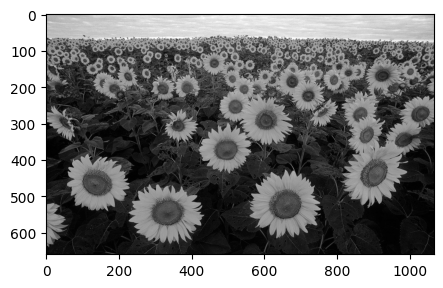

In [21]:
path = 'sunflowers.jpg'
im_cv2 = cv2.imread(path)
im = im_cv2.astype(float).mean(2)/255
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im,cmap='gray')
plt.show()

In [22]:
def scaleSpaced(im, sigma, n):
    im_scales = []
    for i in range(n):
        g, _ = gaussian1DKernel(sigma*2**i)
        im_scale = cv2.sepFilter2D(src = im, ddepth=-1, kernelX=g, kernelY=g)
        im_scales.append(im_scale)
    return im_scales


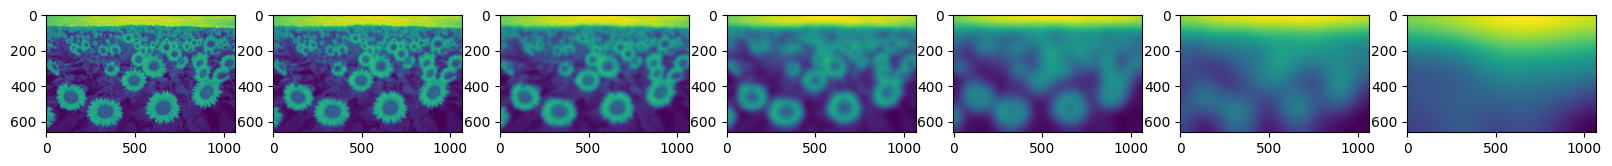

In [23]:
sigma = 2
n = 7
im_scales = scaleSpaced(im, sigma, n)
fig = plt.figure(figsize=(20,10))
for i in range(n):
    ax = fig.add_subplot(1, n, i+1)
    ax.imshow(im_scales[i])
plt.show()

8.2

In [24]:
def differenceOfGaussians(im, sigma, n):
    DoGs = []
    im_scales = []
    for i in range(n):
        g, _ = gaussian1DKernel(sigma*2**i)
        im_scale = cv2.sepFilter2D(src = im, ddepth=-1, kernelX=g, kernelY=g)
        im_scales.append(im_scale)
        if i == 0:
            continue
        else:
            DoGs.append(im_scale-im_scales[i-1])  
    return DoGs

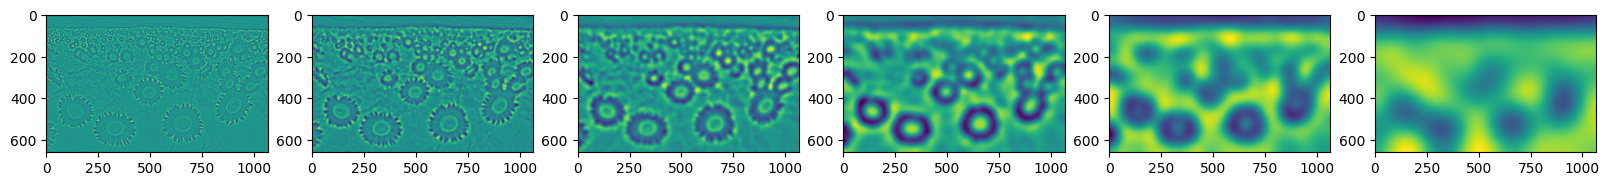

In [25]:
DoGs = differenceOfGaussians(im, sigma, n)
fig = plt.figure(figsize=(20,10))
for i in range(n-1):
    ax = fig.add_subplot(1, n-1, i+1)
    ax.imshow(DoGs[i])
plt.show()

8.3

In [26]:
def detectBlobs(im, sigma, n, tau):
    DoGs = differenceOfGaussians(im, sigma, n)
    abs_DoGs = []
    MaxDoGs = []
    mask_DoGs = []
    blobs = []
    for i in range(n-1):
        abs_DoGs.append(abs(DoGs[i]))
        MaxDoGs.append(cv2.dilate(abs_DoGs[i], np.ones((3,3))))
        mask_DoGs.append(abs_DoGs[i]>tau)
        
    for i in range(n-1):
        mask_DoGs[i] *= abs_DoGs[i]==MaxDoGs[i]
        if i>0:
            mask_DoGs[i] *= abs_DoGs[i]>MaxDoGs[i-1]
        if i<n-2:
            mask_DoGs[i] *= abs_DoGs[i]>MaxDoGs[i+1]
        blob = np.where(mask_DoGs[i])
        blob = np.array([blob[1],blob[0]])
        blobs.append(blob)
    return blobs

858
179
78
43
14
4


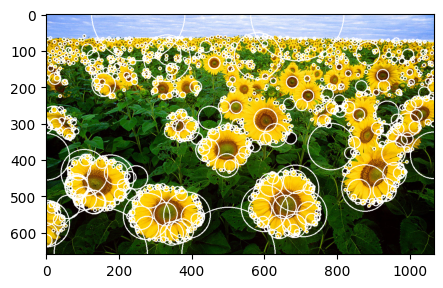

In [27]:
tau = 0.1
blobs = detectBlobs(im, sigma, n, tau)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im)
im_blobs = im_cv2.copy()
for i in range(n-1):
    print(blobs[i].shape[1])
    for j in range(blobs[i].shape[1]):
        im_blobs = cv2.circle(im_blobs, blobs[i][:,j], 2*sigma*2**i, (255, 255, 255), 2)
im_blobs = im_blobs[:,:,::-1]
ax.imshow(im_blobs)
plt.show()

8.4

In [28]:
def transformIm(im, theta, s):
    width = int(im.shape[1] * s)
    height = int(im.shape[0] * s)
    dim = (width, height)
    
    r_im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    image_center = tuple(np.array(r_im.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    r_im = cv2.warpAffine(r_im, rot_mat, r_im.shape[1::-1], flags=cv2.INTER_LINEAR)
  
    return r_im

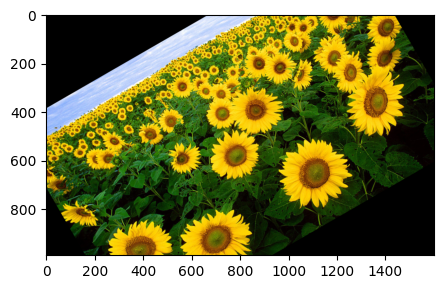

In [29]:
theta = 30
s = 1.5
r_im_cv2 = transformIm(im_cv2, theta, s)
r_im = r_im_cv2[:,:,::-1]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(r_im)
plt.show()

8.5

19


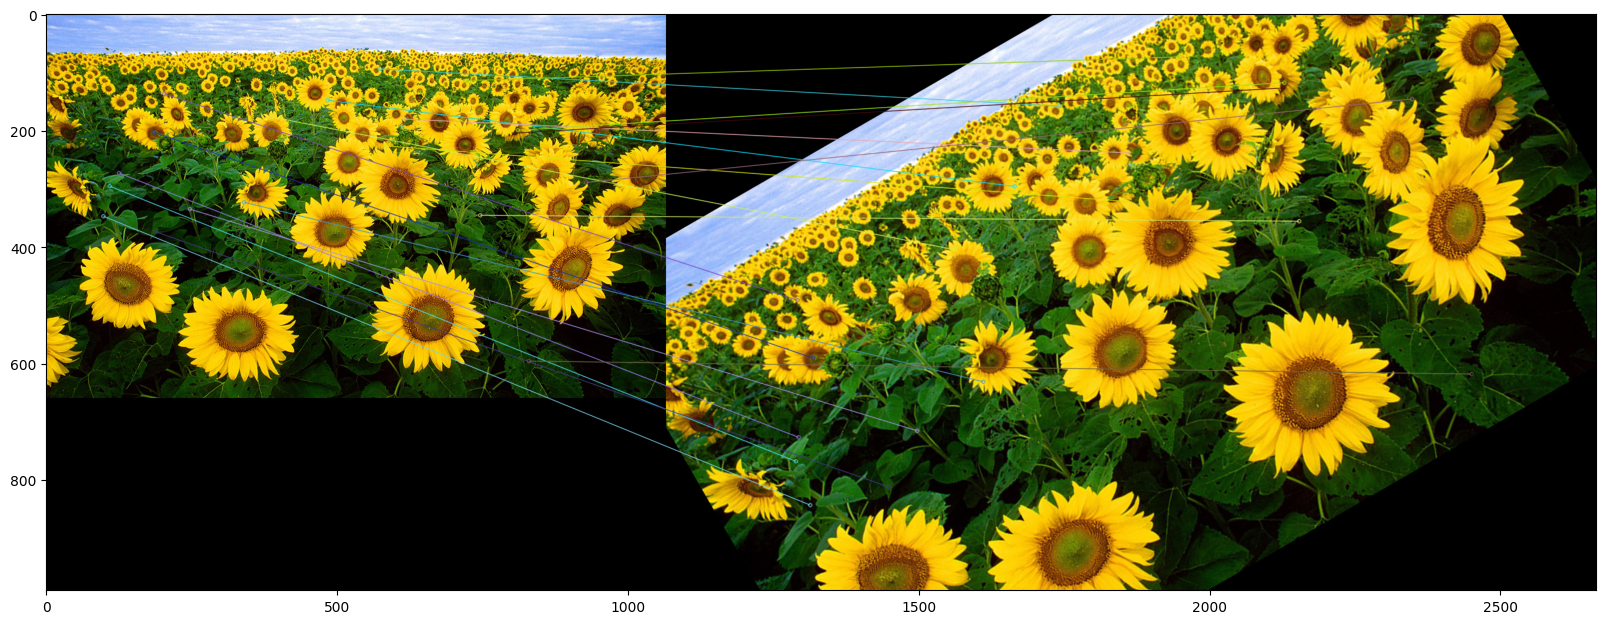

In [30]:

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im_cv2,None)
kp2, des2 = sift.detectAndCompute(r_im_cv2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    # Apply the Lowe criterion best should be closer than second best
    if m.distance/(n.distance + 10e-10) < 0.1:
        good.append([m])
print(len(good))
# cv.drawMatchesKnn expects list of lists as matches.
im_sift = cv2.drawMatchesKnn(im_cv2,kp1,r_im_cv2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im_sift)
plt.show()

8.6

74


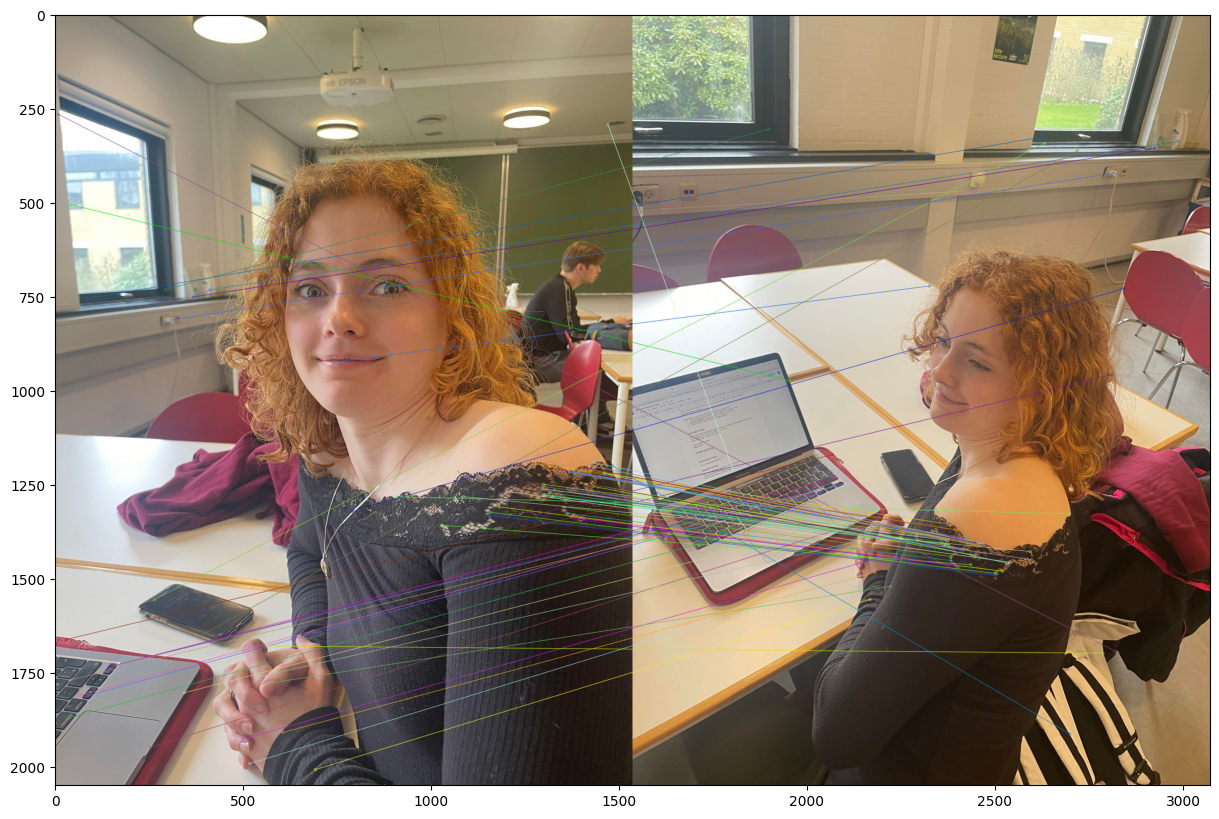

In [31]:
path1 = 'im_1.jpg'
im_cv2_1 = cv2.imread(path1)
path2 = 'im_2.jpg'
im_cv2_2 = cv2.imread(path2)

im_1 = im_cv2_1.astype(float).mean(2)/255
im_2 = im_cv2_2.astype(float).mean(2)/255

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im_cv2_1,None)
kp2, des2 = sift.detectAndCompute(im_cv2_2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    # Apply the Lowe criterion best should be closer than second best
    if m.distance/(n.distance + 10e-10) < 0.7:
        good.append([m])
print(len(good))
# cv.drawMatchesKnn expects list of lists as matches.
im_sift = cv2.drawMatchesKnn(im_cv2_1,kp1,im_cv2_2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(im_sift)
plt.show()